In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib_venn as venn
import warnings

df = pd.read_csv("pax_data_195_agreements_19-04-21.csv")
df["Dat"] = pd.to_datetime(df["Dat"])
df["Year"] = pd.to_datetime(df["Dat"]).apply(lambda x: x.year)
duration_of_PP = (df.sort_values("Dat").groupby(["PPName"]).Dat.agg("last")-df.sort_values("Dat").groupby(["PPName"])\
 .Dat.agg("first")).apply(lambda x: x.days)

#Aïllament i transformació de factors
factors = df.iloc[:,27:-2].astype(bool).astype(int)

#Correlació entre factors

top_20_factors = factors.sum().sort_values(ascending = False)[:20] 
corr = abs(factors[top_20_factors.index].corr())
corr[corr < 0.5] = 0
corr[corr == 1] = 0
corr_no_zero = corr.loc[~(corr==0).all(axis=1)].index
corr = corr.loc[corr_no_zero,corr_no_zero]

#Coocurrència entre factors
cooc = factors.T.dot(factors)

font_text = {'size'  : 18}


font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font_text)
warnings.filterwarnings('ignore')

# Dashboard de visualitzacions quantitatives de la co-ocurrència en tractats de pau a LATAM de mencions als drets de la dona i dels indígenes


## Qualitat de les dades

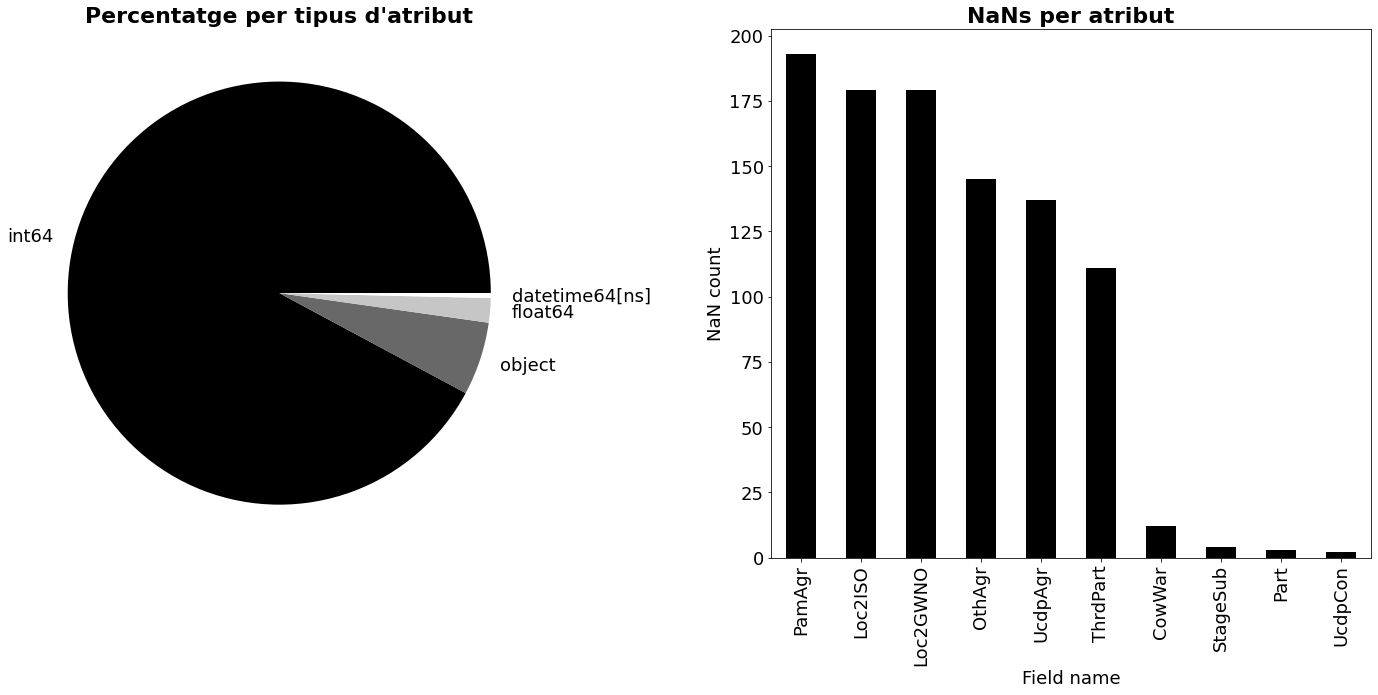

In [2]:
plt.subplot(1,2,1)
df.dtypes.value_counts().plot.pie(figsize=(20, 15),cmap="Greys_r")
plt.title("Percentatge per tipus d'atribut",fontdict=font)
plt.ylabel("")
plt.subplot(1,2,2)
plt.title("NaNs per atribut",fontdict=font)
df.isna().sum().sort_values(ascending=False)[:10].plot.bar(figsize=(20, 10),cmap="Greys_r")
plt.ylabel("NaN count")
plt.xlabel("Field name")
plt.tight_layout()
plt.show()

## Intuició global dels tractats de pau a Amèrica

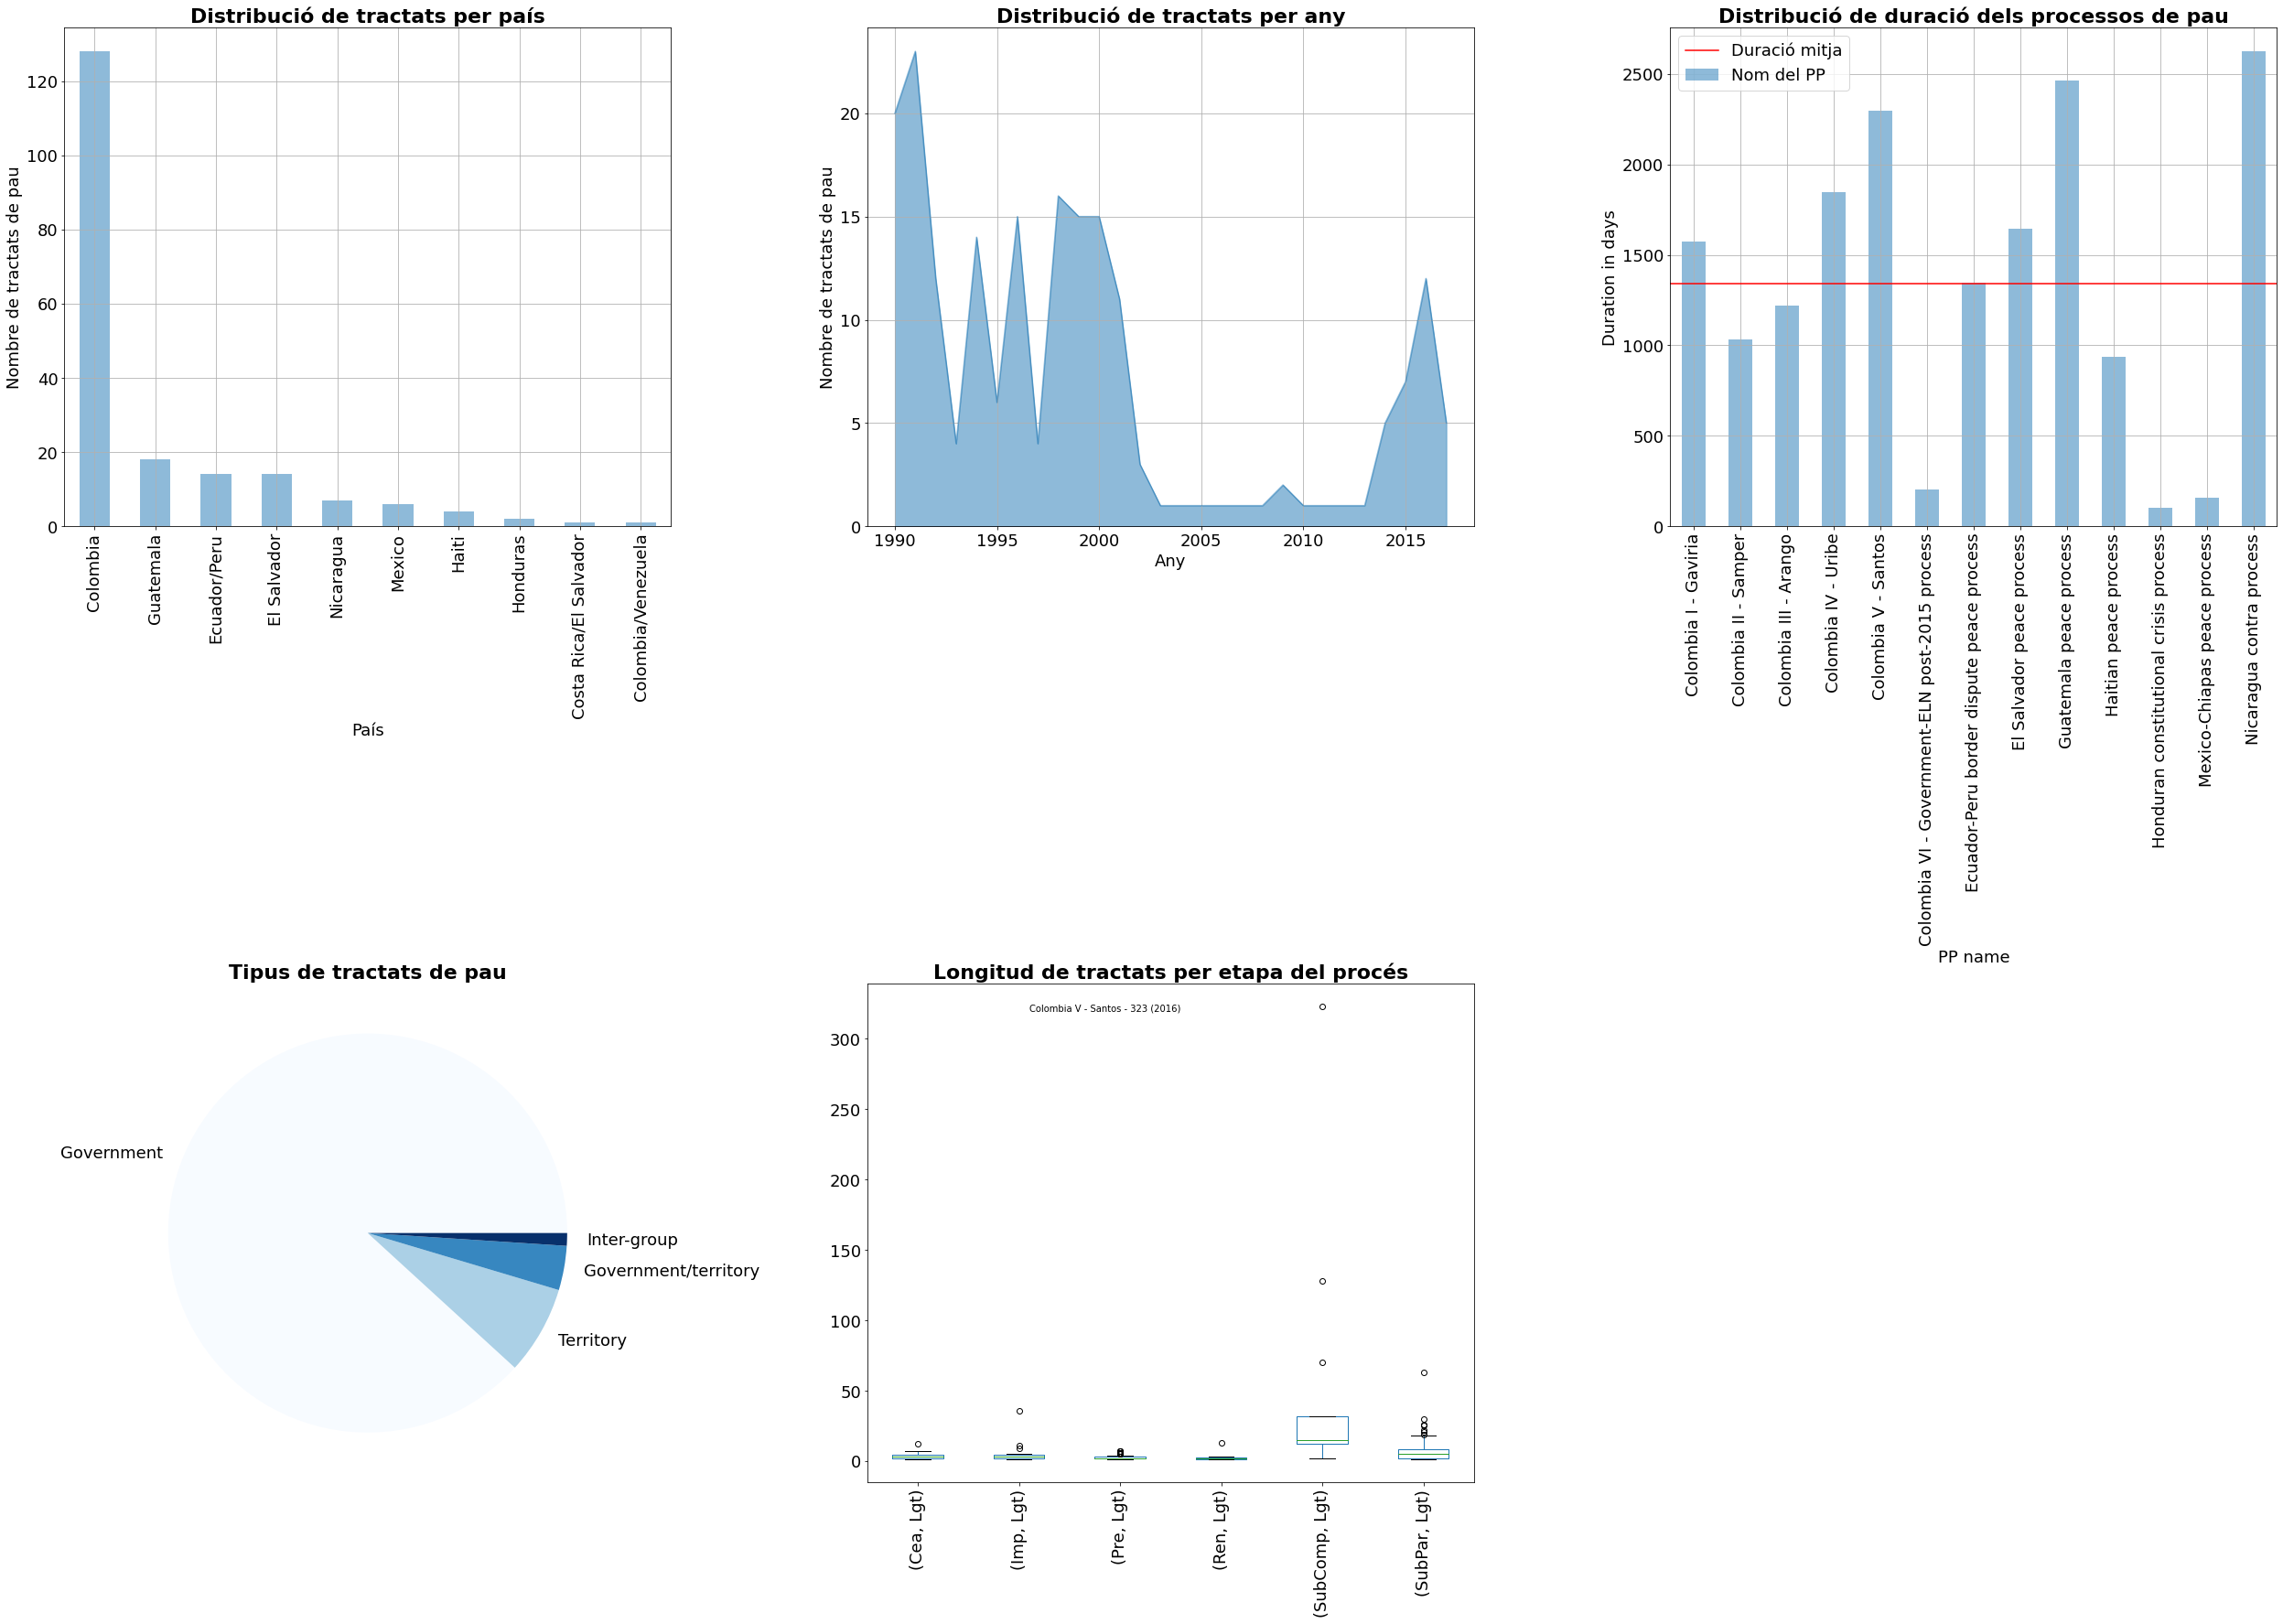

In [3]:
ax = plt.subplot(2,3,1)
plt.title("Distribució de tractats per país",fontdict=font)
df["Con"].value_counts().plot.bar(alpha=0.5,figsize=(35,25))
plt.ylabel("Nombre de tractats de pau")
plt.xlabel("País")
ax.set_xticklabels(item.get_text()[:min(len(item.get_text()),22)] for item in ax.get_xticklabels())
ax.grid(b=None)
ax.set_facecolor('white')

ax = plt.subplot(2,3,2)
plt.title("Distribució de tractats per any",fontdict=font)
df.Year.value_counts().sort_index().plot.area(alpha = 0.5)
plt.ylabel("Nombre de tractats de pau")
plt.xlabel("Any")
ax.grid(b=None)
ax.set_facecolor('white')

ax = plt.subplot(2,3,3)
plt.title("Distribució de duració dels processos de pau",fontdict=font)
duration_of_PP.plot.bar(alpha = 0.5,label="Nom del PP")
plt.plot((-1,15),[duration_of_PP.mean(),duration_of_PP.mean()],"r",label="Duració mitja")
plt.legend()
plt.ylabel("Duration in days")
plt.xlabel("PP name")
ax.grid(b=None)
ax.set_facecolor('white')

ax = plt.subplot(2,3,4)

plt.title("Tipus de tractats de pau",fontdict=font)
df.Contp.value_counts().plot.pie(cmap="Blues")
plt.ylabel("")
ax.grid(b=None)
ax.set_facecolor('white')

ax = plt.subplot(2,3,5)

plt.title("Longitud de tractats per etapa del procés",fontdict=font)
df[["Stage","Lgt"]].groupby("Stage").boxplot("Lgt",figsize=(8,5))
maxlen = df.iloc[df.Lgt.idxmax()]
plt.text(2.1,320,"{0} - {1} ({2})".format(maxlen.PPName,maxlen.Lgt,maxlen.Dat.year), fontdict={"fontsize":10})
plt.xticks(rotation="vertical")
ax.grid(b=None)
ax.set_facecolor('white')

plt.tight_layout()

plt.show()

## Correlacions i co-ocurrències: Estudi del cas GInd - GeWom 

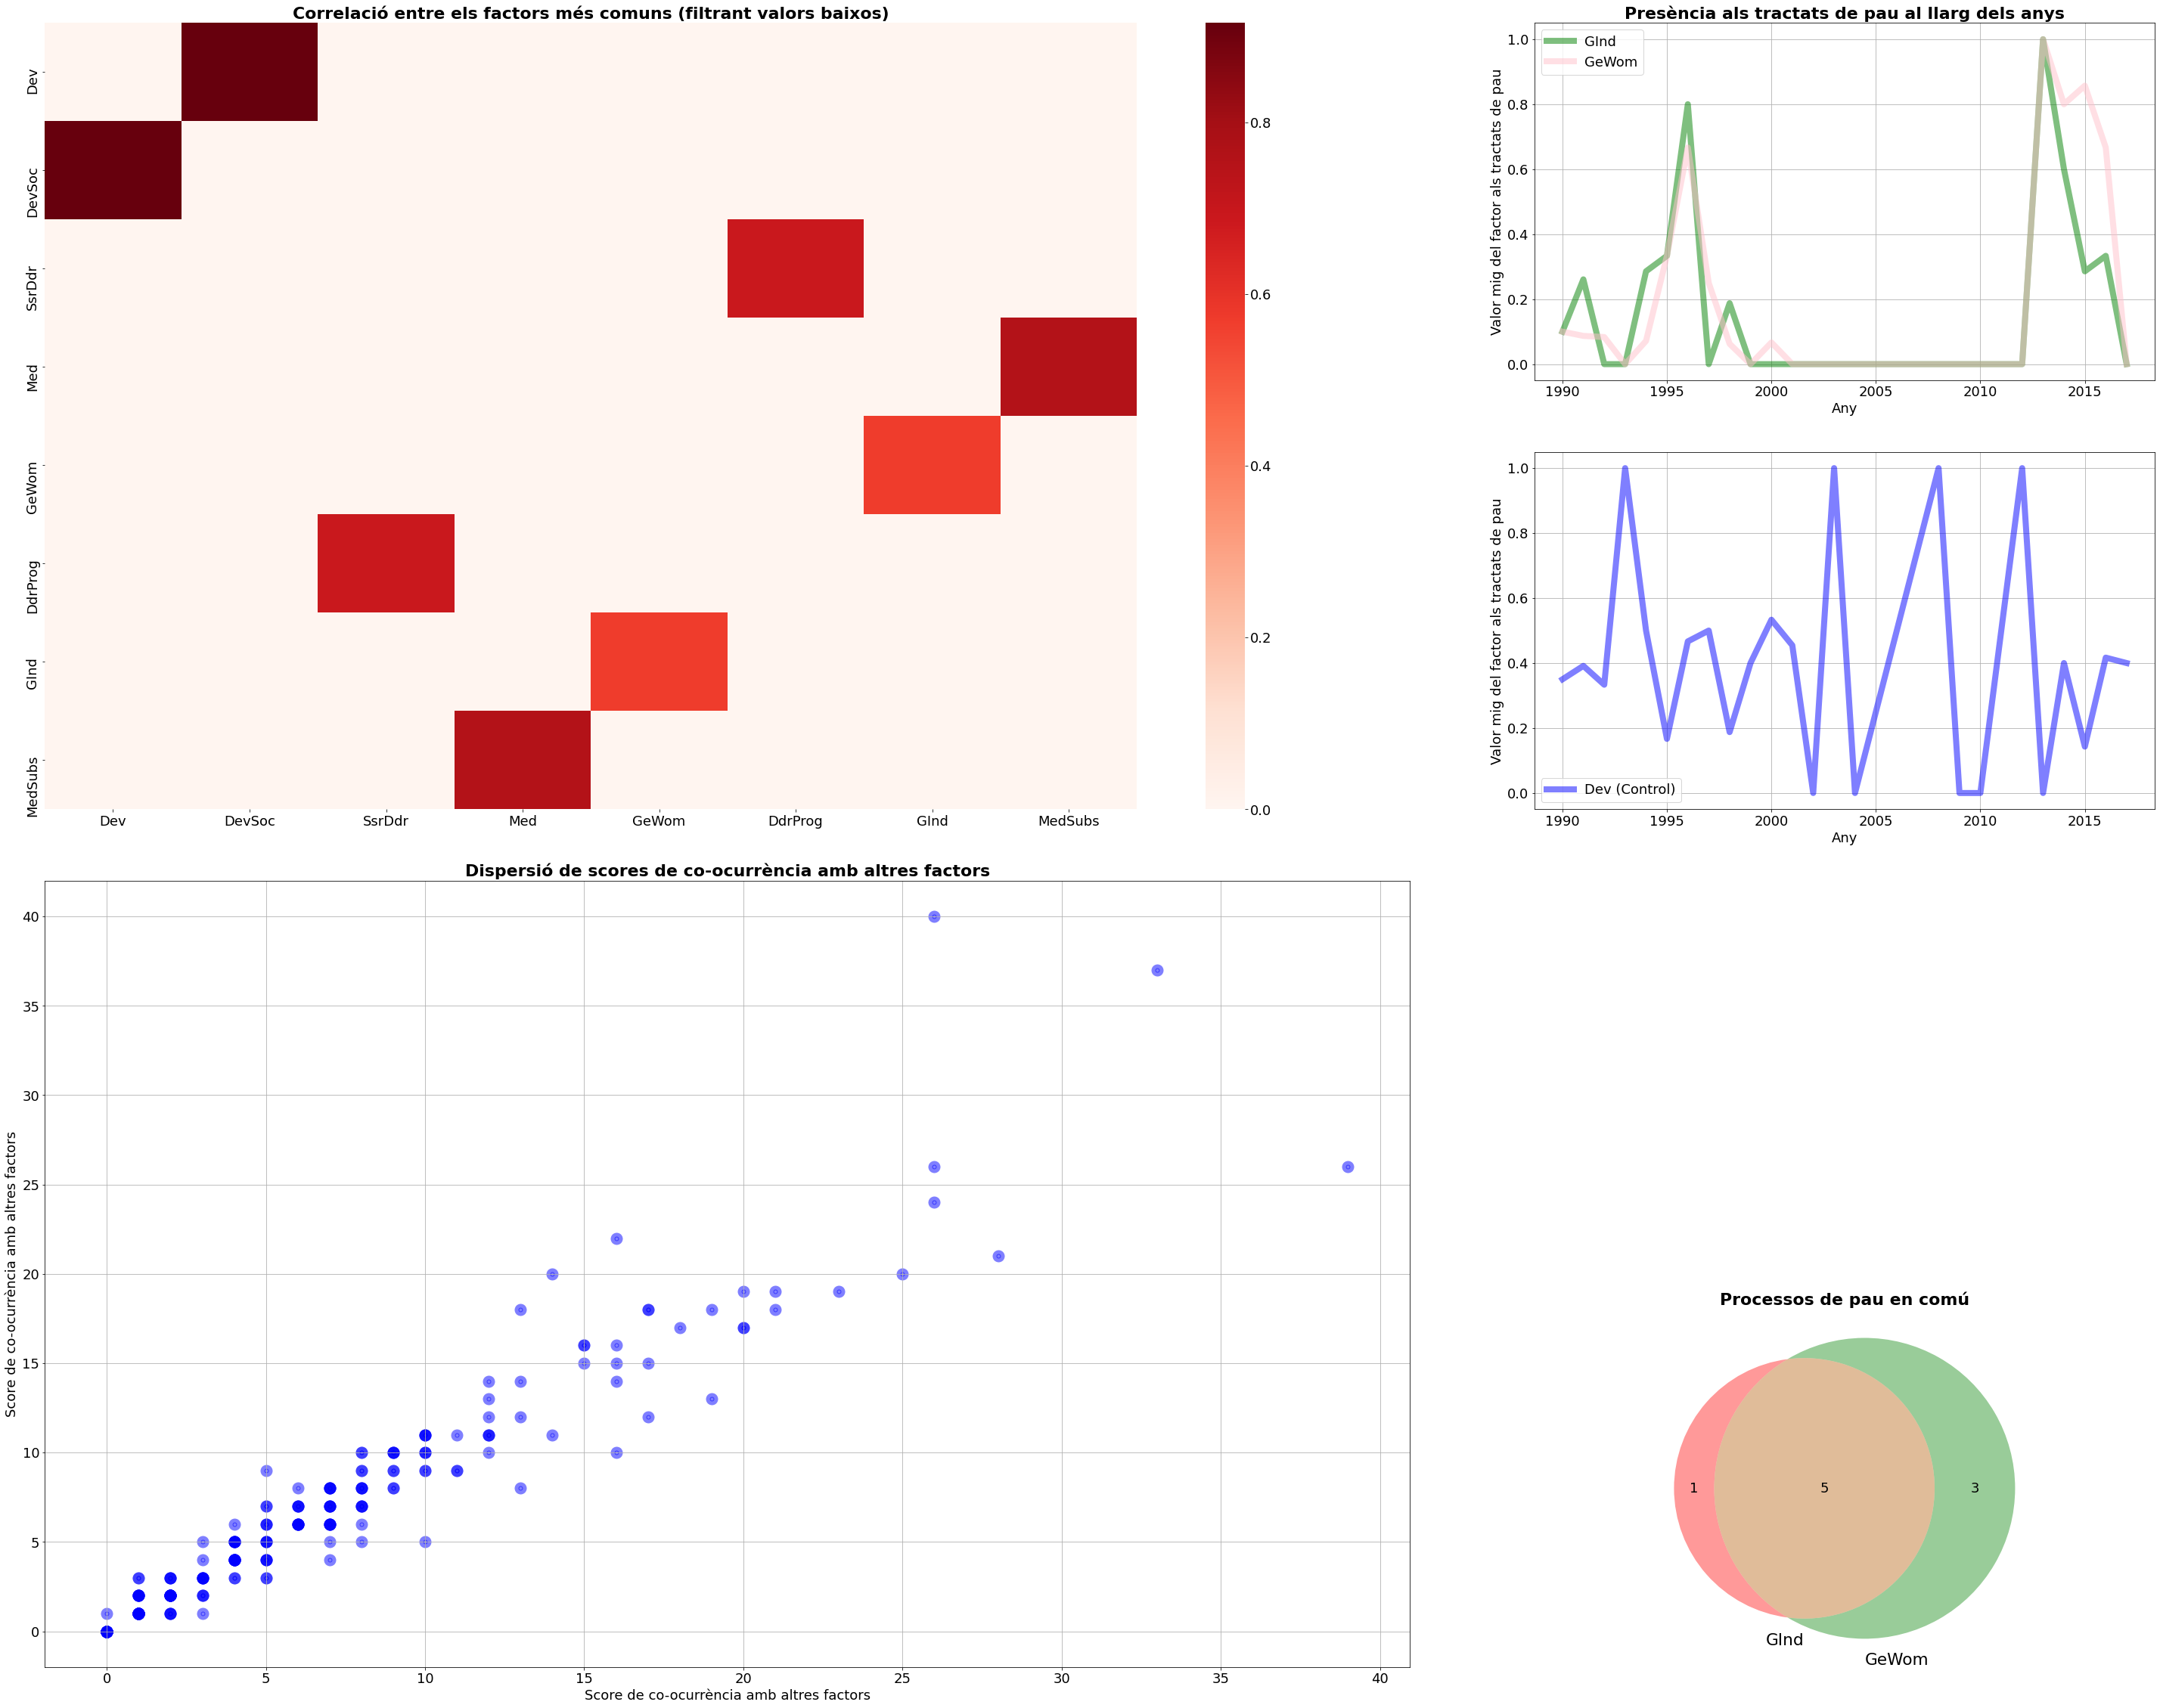

In [4]:
fig = plt.figure(figsize=(50,40))
ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=2, rowspan = 2)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap = "Reds")
plt.title("Correlació entre els factors més comuns (filtrant valors baixos)",fontdict=font)


ax2 = plt.subplot2grid((4, 3), (0, 2))

df.groupby("Year").GInd.apply(lambda x: np.mean(x.astype(bool).astype(int))).plot(c="g",alpha=0.5,linewidth=8,label="GInd")
df.groupby("Year").GeWom.apply(lambda x: np.mean(x.astype(bool).astype(int))).plot(c="pink",alpha=0.5,linewidth=8,label="GeWom")
plt.ylabel("Valor mig del factor als tractats de pau",fontdict=font_text)
plt.xlabel("Any",fontdict=font_text)
plt.grid(b=None)
ax2.set_facecolor('white')
plt.legend()
plt.title("Presència als tractats de pau al llarg dels anys",fontdict=font)


ax3 = plt.subplot2grid((4, 3), (1, 2))

df.groupby("Year").Dev.apply(lambda x: np.mean(x.astype(bool).astype(int))).plot(c="b",alpha=0.5,linewidth=8,label="Dev (Control)")
plt.ylabel("Valor mig del factor als tractats de pau",fontdict=font_text)
plt.xlabel("Any",fontdict=font_text)
plt.grid(b=None)
ax3.set_facecolor('white')
plt.legend()


ax4 = plt.subplot2grid((4, 3), (2, 0), colspan=2, rowspan = 2)

ax4.scatter(cooc["GInd"],cooc["GeWom"],c="b",alpha=0.5,linewidth=10)
plt.grid(b=None)
ax4.set_facecolor('white')
plt.title("Dispersió de scores de co-ocurrència amb altres factors",fontdict=font)
plt.xlabel("Score de co-ocurrència amb altres factors",fontdict=font_text)
plt.ylabel("Score de co-ocurrència amb altres factors",fontdict=font_text)

ax5 = plt.subplot2grid((4, 3), (3, 2),colspan=1)

a = set(df[df.GInd > 0].PPName.unique())
b = set(df[df.GeWom > 0].PPName.unique())
venn.venn2([a,b],set_labels=('GInd','GeWom'))
plt.title("Processos de pau en comú",fontdict=font)

plt.show()